### Practical Implementation of Gradient Boosted Algorithms

In [1]:
!pip install wurlitzer

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)


{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

In [4]:
X.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [89]:
X.size

5327280

In [6]:
# Looking at the outcome variable to see if binary or multiclass
y.value_counts()

Diabetes_binary
0                  218334
1                   35346
Name: count, dtype: int64

### Best features correlated with target

Correlation with target variable:
target                  1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
BMI                     0.216843
HighChol                0.200276
Age                     0.177442
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Income                 -0.163919
Education              -0.124456
PhysActivity           -0.118133
Stroke                  0.105816
MentHlth                0.069315
CholCheck               0.064761
Smoker                  0.060789
HvyAlcoholConsump      -0.057056
Veggies                -0.056584
Fruits                 -0.040779
NoDocbcCost             0.031433
Sex                     0.031430
AnyHealthcare           0.016255
Name: target, dtype: float64


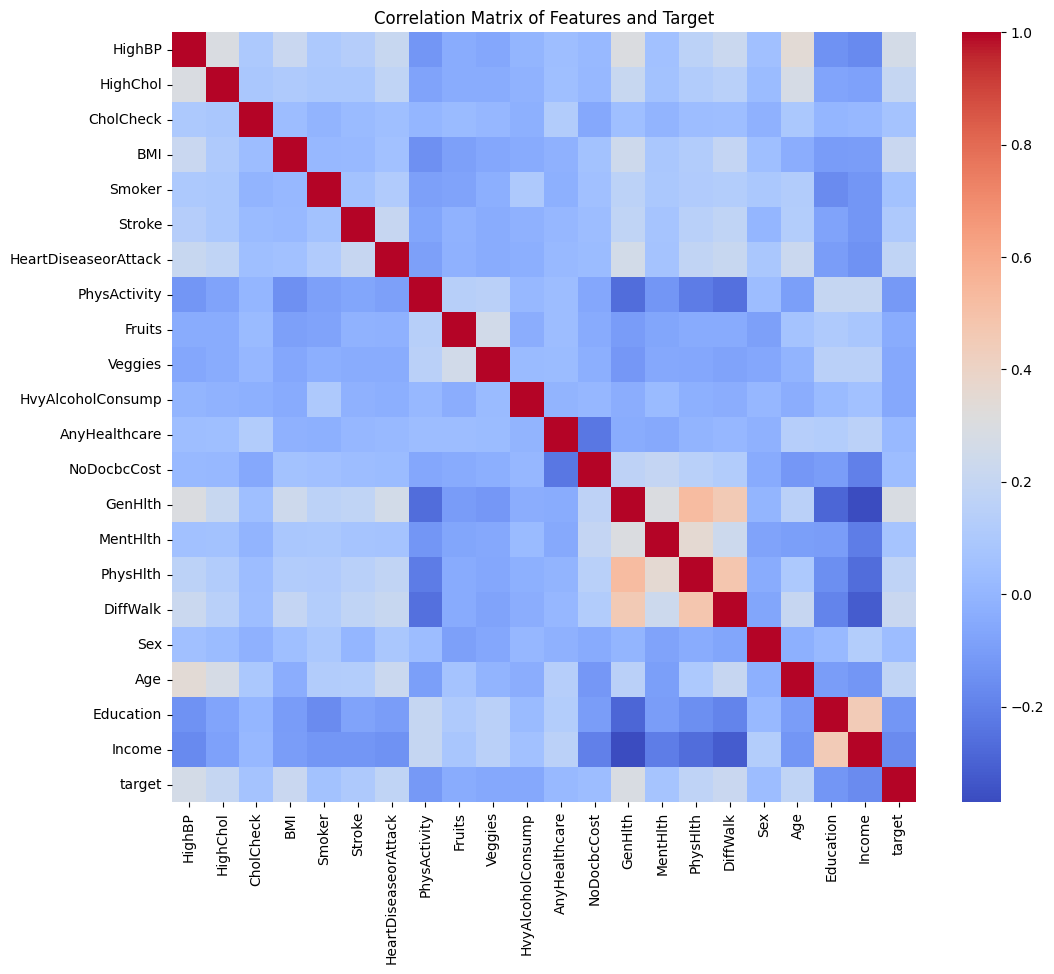

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Concatenate X and y for correlation calculation
df_corr = X.copy()
df_corr['target'] = y

# Calculate the correlation matrix
corr_matrix = df_corr.corr()

# Get correlations with the target variable and sort by absolute value
target_corr = corr_matrix['target'].sort_values(key=abs, ascending=False)

# Print the correlations with the target
print("Correlation with target variable:")
print(target_corr)

# Plot heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Target')
plt.show()

In [8]:
best_correlated_variables = target_corr[abs(target_corr) > 0.2]
print("Variables with correlation greater than 0.2 with the target variable:")
print(best_correlated_variables)

Variables with correlation greater than 0.2 with the target variable:
target      1.000000
GenHlth     0.293569
HighBP      0.263129
DiffWalk    0.218344
BMI         0.216843
HighChol    0.200276
Name: target, dtype: float64


#### From heat map we can see some feature correlation such as survey question Genhlth having moderate to low-high correlation with PhysHlth, and so forth.


In [9]:
# Select columns from X that are in best_correlated_variables (excluding 'target')
X_correlated = X[best_correlated_variables.drop('target').index]

# Display the first few rows of the new DataFrame
display(X_correlated.head())

GenHlth  HighBP  DiffWalk  BMI  HighChol
0        5       1         1   40         1
1        3       0         0   25         0
2        5       1         1   28         1
3        2       1         0   27         0
4        2       1         0   24         1

In [ ]:
# !pip install shap

In [10]:
## install packges
!pip install wurlitzer
!pip install ydf ## Install YDF
!pip install xgboost-cpu ## Install XgBoost
!pip install lightgbm ## Install Light GBM
!pip install catboost ## Install CatBoost
!pip install dask[dataframe]
!pip install tensorflow_decision_forests
!pip install ydf -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


In [11]:
## Import sklearn metrics and dataset
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [12]:
## Extract dataframe from the dataset
X.head()

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1   28       0       0                     0   
3       1         0          1   27       0       0                     0   
4       1         1          1   24       0       0                     0   

   PhysActivity  Fruits  Veggies  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0             0       0        1  ...              1            0        5   
1             1       0        0  ...              0            1        3   
2             0       1        0  ...              1            1        5   
3             1       1        1  ...              1            0        2   
4             1       1        1  ...              1            0        2   

   MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  
0        18        15         1    0    9          4       3  
1         0         0         0    0    7          6       1  
2        30        30         1    0    9          4       8  
3         0         0         0    0   11          3       6  
4         3         0         0    0   11          5       4  

[5 rows x 21 columns]

In [13]:
X_correlated.head()

GenHlth  HighBP  DiffWalk  BMI  HighChol
0        5       1         1   40         1
1        3       0         0   25         0
2        5       1         1   28         1
3        2       1         0   27         0
4        2       1         0   24         1

In [14]:
X.shape, y.value_counts()

((253680, 21),
 Diabetes_binary
 0                  218334
 1                   35346
 Name: count, dtype: int64)

In [15]:
X_correlated.shape, y.value_counts()

((253680, 5),
 Diabetes_binary
 0                  218334
 1                   35346
 Name: count, dtype: int64)

In [16]:
X_correlated_y = pd.concat([X_correlated,y],axis=1)

In [17]:
X_all_y = pd.concat([X,y],axis=1)

In [ ]:
y.head(3)

Diabetes_binary
0                0
1                0
2                0

In [18]:
X_all_y.head(5)

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  HeartDiseaseorAttack  \
0       1         1          1   40       1       0                     0   
1       0         0          0   25       1       0                     0   
2       1         1          1   28       0       0                     0   
3       1         0          1   27       0       0                     0   
4       1         1          1   24       0       0                     0   

   PhysActivity  Fruits  Veggies  ...  NoDocbcCost  GenHlth  MentHlth  \
0             0       0        1  ...            0        5        18   
1             1       0        0  ...            1        3         0   
2             0       1        0  ...            1        5        30   
3             1       1        1  ...            0        2         0   
4             1       1        1  ...            0        2         3   

   PhysHlth  DiffWalk  Sex  Age  Education  Income  Diabetes_binary  
0        15         1    0    9          4       3                0  
1         0         0    0    7          6       1                0  
2        30         1    0    9          4       8                0  
3         0         0    0   11          3       6                0  
4         0         0    0   11          5       4                0  

[5 rows x 22 columns]

In [19]:
## split the dataframe in to train and test sample with same random_state and test size
Train_df, Test_df = train_test_split(X_all_y,test_size=0.2, stratify= X_all_y['Diabetes_binary'],random_state=42)
Correlated_Train_df,Correlated_Test_df = train_test_split(X_correlated_y,test_size=0.2, stratify= X_correlated_y['Diabetes_binary'],random_state=42)

In [20]:
# data_train, data_test, target_train, target_test = train_test_split(X,
#                                                                    y,
#                                                                    test_size= .20,
#                                                                    random_state= 42)

In [21]:
# Correlated_data_train, Correlated_data_test, target_train, target_test = train_test_split(X_correlated,
#                                                                    y,
#                                                                    test_size= .20,
#                                                                    random_state= 42)

In [22]:
Train_df.shape, Train_df['Diabetes_binary'].value_counts()

((202944, 22),
 Diabetes_binary
 0    174667
 1     28277
 Name: count, dtype: int64)

In [23]:
Test_df.shape, Test_df['Diabetes_binary'].value_counts()

((50736, 22),
 Diabetes_binary
 0    43667
 1     7069
 Name: count, dtype: int64)

In [24]:
## For XgBoost, LightGBM, CatBoost, TF-DF random forest and YDF random forest, separate the target variable from the train and test df
train_df_wo_target = Train_df.drop(columns=['Diabetes_binary'])
test_df_wo_target = Test_df.drop(columns=['Diabetes_binary'])
train_target = Train_df['Diabetes_binary']
test_target = Test_df['Diabetes_binary']

In [25]:
## for XgBoost, LightGBM, CatBoost, TF-DF random forest and YDF random forest, separate the target variable from the train and test df for correlated DF
Corr_train_df_wo_target = Correlated_Train_df.drop(columns=['Diabetes_binary'])
Corr_test_df_wo_target = Correlated_Test_df.drop(columns=['Diabetes_binary'])
train_target = Train_df['Diabetes_binary']
test_target = Test_df['Diabetes_binary']

In [26]:
Corr_test_df_wo_target.head(2)

GenHlth  HighBP  DiffWalk  BMI  HighChol
128677        3       1         0   28         1
225051        3       1         1   36         0

In [27]:
train_df_wo_target.head(2)

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
153147       0         0          1   28       1       0   
176137       1         0          1   23       1       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  \
153147                     0             1       1        1  ...   
176137                     0             1       1        1  ...   

        AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  \
153147              1            0        2         0         0         0   
176137              1            0        2         0         0         0   

        Sex  Age  Education  Income  
153147    1    2          4       5  
176137    1   13          4       7  

[2 rows x 21 columns]

In [28]:
train_target.head(2)

153147    0
176137    0
Name: Diabetes_binary, dtype: int64

### XgBoost

In [29]:
Corr_train_df_wo_target.head(5)

GenHlth  HighBP  DiffWalk  BMI  HighChol
153147        2       0         0   28         0
176137        2       1         0   23         0
175578        1       1         0   29         1
177887        4       1         0   39         1
182143        5       0         1   16         1

In [30]:
Corr_test_df_wo_target.head(2)

GenHlth  HighBP  DiffWalk  BMI  HighChol
128677        3       1         0   28         1
225051        3       1         1   36         0

In [31]:
import xgboost as xgb

## Define XgBoost classifier with default optiopns
clf_xgboost = xgb.XGBClassifier()
Corr_clf_xgboost = xgb.XGBClassifier()



# Fit the model
clf_xgboost.fit(train_df_wo_target, train_target)
Corr_clf_xgboost.fit(Corr_train_df_wo_target, train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [32]:
print(f'All feature Accuracy: {clf_xgboost.score(test_df_wo_target, test_target)}')
print(f' All feature ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_xgboost.predict_proba(test_df_wo_target)[:,1])}')

All feature Accuracy: 0.8633711762850835
 All feature ROC AUC: 0.8237115900980083


In [33]:
print(f'Correlated feature Accuracy: {Corr_clf_xgboost.score(Corr_test_df_wo_target, test_target)}')
print(f'Correlated feature ROC AUC: {sklearn.metrics.roc_auc_score(test_target, Corr_clf_xgboost.predict_proba(Corr_test_df_wo_target)[:,1])}')

Correlated feature Accuracy: 0.8648691264585304
Correlated feature ROC AUC: 0.804164905968625


In [34]:
from sklearn.metrics import confusion_matrix

# Get predictions for both models on training data
y_pred_xgboost_train = clf_xgboost.predict(train_df_wo_target)
y_pred_corr_xgboost_train = Corr_clf_xgboost.predict(Corr_train_df_wo_target)

# Calculate confusion matrices for training data
cm_xgboost_train = confusion_matrix(train_target, y_pred_xgboost_train)
cm_corr_xgboost_train = confusion_matrix(train_target, y_pred_corr_xgboost_train)

# Extract sensitivity and specificity for training data
tn_xgboost_train, fp_xgboost_train, fn_xgboost_train, tp_xgboost_train = cm_xgboost_train.ravel()
sensitivity_xgboost_train = tp_xgboost_train / (tp_xgboost_train + fn_xgboost_train)
specificity_xgboost_train = tn_xgboost_train / (tn_xgboost_train + fp_xgboost_train)

tn_corr_xgboost_train, fp_corr_xgboost_train, fn_corr_xgboost_train, tp_corr_xgboost_train = cm_corr_xgboost_train.ravel()
sensitivity_corr_xgboost_train = tp_corr_xgboost_train / (tp_corr_xgboost_train + fn_corr_xgboost_train)
specificity_corr_xgboost_train = tn_corr_xgboost_train / (tn_corr_xgboost_train + fp_corr_xgboost_train)

# Print the results side-by-side
print("XGBoost Training Metrics:")
print("Metric        | All Features | Correlated Features")
print("--------------|--------------|--------------------")
print(f"Accuracy      | {clf_xgboost.score(train_df_wo_target, train_target):.4f}     | {Corr_clf_xgboost.score(Corr_train_df_wo_target, train_target):.4f}")
print(f"ROC AUC       | {sklearn.metrics.roc_auc_score(train_target, clf_xgboost.predict_proba(train_df_wo_target)[:,1]):.4f}     | {sklearn.metrics.roc_auc_score(train_target, Corr_clf_xgboost.predict_proba(Corr_train_df_wo_target)[:,1]):.4f}")
print(f"Sensitivity   | {sensitivity_xgboost_train:.4f}     | {sensitivity_corr_xgboost_train:.4f}")
print(f"Specificity   | {specificity_xgboost_train:.4f}     | {specificity_corr_xgboost_train:.4f}")

XGBoost Training Metrics:
Metric        | All Features | Correlated Features
--------------|--------------|--------------------
Accuracy      | 0.8765     | 0.8661
ROC AUC       | 0.8569     | 0.8139
Sensitivity   | 0.2140     | 0.1311
Specificity   | 0.9838     | 0.9850


Model training on all features had better AUC, accuracy, sensitivity, specificity, hence going to procced with all features for subsequent models since XGBoost is supposed to be the most robust for classification to avoid time wasting.


In [35]:
from sklearn.metrics import confusion_matrix

# Get predictions for both models
y_pred_xgboost = clf_xgboost.predict(test_df_wo_target)
y_pred_corr_xgboost = Corr_clf_xgboost.predict(Corr_test_df_wo_target)

# Calculate confusion matrices
cm_xgboost = confusion_matrix(test_target, y_pred_xgboost)
cm_corr_xgboost = confusion_matrix(test_target, y_pred_corr_xgboost)

# Extract sensitivity and specificity
# Sensitivity = True Positive / (True Positive + False Negative)
# Specificity = True Negative / (True Negative + False Positive)

tn_xgboost, fp_xgboost, fn_xgboost, tp_xgboost = cm_xgboost.ravel()
sensitivity_xgboost = tp_xgboost / (tp_xgboost + fn_xgboost)
specificity_xgboost = tn_xgboost / (tn_xgboost + fp_xgboost)

tn_corr_xgboost, fp_corr_xgboost, fn_corr_xgboost, tp_corr_xgboost = cm_corr_xgboost.ravel()
sensitivity_corr_xgboost = tp_corr_xgboost / (tp_corr_xgboost + fn_corr_xgboost)
specificity_corr_xgboost = tn_corr_xgboost / (tn_corr_xgboost + fp_corr_xgboost)

# Print the results side-by-side
print("XGBoost Testing Metrics:")
print("Metric        | All Features | Correlated Features")
print("--------------|--------------|--------------------")
print(f"Sensitivity   | {sensitivity_xgboost:.4f}     | {sensitivity_corr_xgboost:.4f}")
print(f"Specificity   | {specificity_xgboost:.4f}     | {specificity_corr_xgboost:.4f}")

XGBoost Testing Metrics:
Metric        | All Features | Correlated Features
--------------|--------------|--------------------
Sensitivity   | 0.1665     | 0.1270
Specificity   | 0.9762     | 0.9843


In [36]:
print(""" Here the model with high correlated(>0.2) features has a slightly better accuracy score but model with all features has better AUC score,
hence since senstivity is better here with low false positive indicating beter specificity, i will the model with all features, its a better balanced model""" )

 Here the model with high correlated(>0.2) features has a slightly better accuracy score but model with all features has better AUC score,
hence since senstivity is better here with low false positive indicating beter specificity, i will the model with all features, its a better balanced model


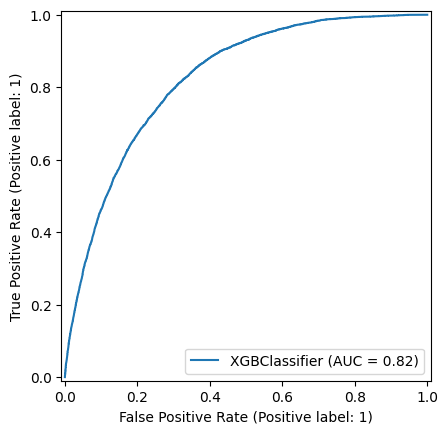

In [37]:
# using all features
sklearn.metrics.RocCurveDisplay.from_estimator(clf_xgboost, test_df_wo_target, test_target)

### Light GBM - Light Gradient Boosted Model

In [38]:
# import Light GBM
import lightgbm as lgb

## Define Light GBM Classifier
clf_lgb = lgb.sklearn.LGBMClassifier()

# Fit the model,
clf_lgb.fit(train_df_wo_target, train_target)

[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139334 -> initscore=-1.820833
[LightGBM] [Info] Start training from score -1.820833


LGBMClassifier()

In [39]:
print(f'Accuracy: {clf_lgb.score(test_df_wo_target, test_target)}')
print(f'ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_lgb.predict_proba(test_df_wo_target)[:,1])}')

Accuracy: 0.8654998423210344
ROC AUC: 0.8269113293973714


In [40]:
from sklearn.metrics import confusion_matrix

# --- LightGBM Model ---
print("LightGBM Model:")

# Training data metrics
y_pred_lgb_train = clf_lgb.predict(train_df_wo_target)
cm_lgb_train = confusion_matrix(train_target, y_pred_lgb_train)
tn_lgb_train, fp_lgb_train, fn_lgb_train, tp_lgb_train = cm_lgb_train.ravel()
sensitivity_lgb_train = tp_lgb_train / (tp_lgb_train + fn_lgb_train)
specificity_lgb_train = tn_lgb_train / (tn_lgb_train + fp_lgb_train)

print("  Training Metrics:")
print(f'  Accuracy: {clf_lgb.score(train_df_wo_target, train_target)}')
print(f'  ROC AUC: {sklearn.metrics.roc_auc_score(train_target, clf_lgb.predict_proba(train_df_wo_target)[:,1])}')
print(f'  Sensitivity: {sensitivity_lgb_train}')
print(f'  Specificity: {specificity_lgb_train}')

# Testing data metrics
y_pred_lgb_test = clf_lgb.predict(test_df_wo_target)
cm_lgb_test = confusion_matrix(test_target, y_pred_lgb_test)
tn_lgb_test, fp_lgb_test, fn_lgb_test, tp_lgb_test = cm_lgb_test.ravel()
sensitivity_lgb_test = tp_lgb_test / (tp_lgb_test + fn_lgb_test)
specificity_lgb_test = tn_lgb_test / (tn_lgb_test + fp_lgb_test)

print("  Testing Metrics:")
print(f'  Accuracy: {clf_lgb.score(test_df_wo_target, test_target)}')
print(f'  ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_lgb.predict_proba(test_df_wo_target)[:,1])}')
print(f'  Sensitivity: {sensitivity_lgb_test}')
print(f'  Specificity: {specificity_lgb_test}')

LightGBM Model:
  Training Metrics:
  Accuracy: 0.8699838379060233
  ROC AUC: 0.8413326285960876
  Sensitivity: 0.1740990911341373
  Specificity: 0.9826412545014227
  Testing Metrics:
  Accuracy: 0.8654998423210344
  ROC AUC: 0.8269113293973714
  Sensitivity: 0.16395529777903523
  Specificity: 0.9790688620697552


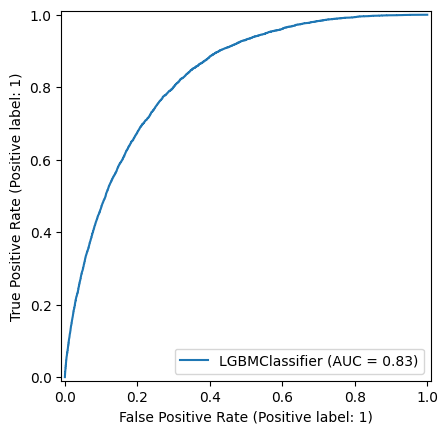

In [41]:
sklearn.metrics.RocCurveDisplay.from_estimator(clf_lgb, test_df_wo_target, test_target)

### YDF Gradient Boosted Trees

In [42]:
## import YDF
import ydf
Train_df.head()

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
153147       0         0          1   28       1       0   
176137       1         0          1   23       1       0   
175578       1         1          1   29       0       0   
177887       1         1          1   39       0       0   
182143       0         1          1   16       1       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  NoDocbcCost  \
153147                     0             1       1        1  ...            0   
176137                     0             1       1        1  ...            0   
175578                     0             1       1        1  ...            0   
177887                     0             0       0        0  ...            0   
182143                     0             1       1        1  ...            1   

        GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  Income  \
153147        2         0         0         0    1    2          4       5   
176137        2         0         0         0    1   13          4       7   
175578        1         0         0         0    1    9          6       8   
177887        4         0         0         0    1    7          4       7   
182143        5        30        30         1    0    7          5       1   

        Diabetes_binary  
153147                0  
176137                0  
175578                0  
177887                0  
182143                0  

[5 rows x 22 columns]

In [43]:
## define and train YDF model
clf_ydf = ydf.GradientBoostedTreesLearner(label='Diabetes_binary').train(Train_df)

Train model on 202944 examples
Model trained in 0:00:54.930300


In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import numpy as np

# --- YDF Model ---
print("YDF Model:")

# Training data metrics
y_pred_ydf_train_proba = clf_ydf.predict(Train_df)  # Get probabilities for ROC AUC
y_pred_ydf_train = clf_ydf.predict_class(Train_df).astype(int) # Get predicted class for accuracy, sensitivity, specificity
cm_ydf_train = confusion_matrix(train_target, y_pred_ydf_train)
tn_ydf_train, fp_ydf_train, fn_ydf_train, tp_ydf_train = cm_ydf_train.ravel()
sensitivity_ydf_train = tp_ydf_train / (tp_ydf_train + fn_ydf_train)
specificity_ydf_train = tn_ydf_train / (tn_ydf_train + fp_ydf_train)

print(" Training Metrics:")
print(f'  Accuracy: {accuracy_score(train_target, y_pred_ydf_train)}')
print(f'  ROC AUC: {roc_auc_score(train_target, y_pred_ydf_train_proba)}')
print(f'  Sensitivity: {sensitivity_ydf_train}')
print(f'  Specificity: {specificity_ydf_train}')

# Testing data metrics
y_pred_ydf_test_proba = clf_ydf.predict(Test_df) # Get probabilities for ROC AUC
y_pred_ydf_test = clf_ydf.predict_class(Test_df).astype(int) # Get predicted class for accuracy, sensitivity, specificity and convert to int
cm_ydf_test = confusion_matrix(test_target, y_pred_ydf_test)
tn_ydf_test, fp_ydf_test, fn_ydf_test, tp_ydf_test = cm_ydf_test.ravel()
sensitivity_ydf_test = tp_ydf_test / (tp_ydf_test + fn_ydf_test)
specificity_ydf_test = tn_ydf_test / (tn_ydf_test + fp_ydf_test)

print(" Testing Metrics:")
print(f'  Accuracy: {accuracy_score(test_target, y_pred_ydf_test)}')
print(f'  ROC AUC: {roc_auc_score(test_target, y_pred_ydf_test_proba)}')
print(f'  Sensitivity: {sensitivity_ydf_test}')
print(f'  Specificity: {specificity_ydf_test}')

YDF Model:
 Training Metrics:
  Accuracy: 0.870333688111006
  ROC AUC: 0.840228204298632
  Sensitivity: 0.1837889450790395
  Specificity: 0.9814790429789256
 Testing Metrics:
  Accuracy: 0.8655786818038473
  ROC AUC: 0.8273007819441432
  Sensitivity: 0.16834064224076956
  Specificity: 0.9784505461790368


In [45]:
# Inspect the YDF model object to find the correct method for probability prediction
print(dir(clf_ydf))
help(clf_ydf.predict)

['__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_build_evaluation_dataspec', '_model', 'activation', 'add_tree', 'analyze', 'analyze_prediction', 'benchmark', 'data_spec', 'describe', 'distance', 'evaluate', 'feature_selection_logs', 'force_engine', 'get_all_trees', 'get_tree', 'hyperparameter_optimizer_logs', 'initial_predictions', 'input_feature_names', 'input_features', 'input_features_col_idxs', 'iter_trees', 'label', 'label_classes', 'label_col_idx', 'list_compatible_engines', 'metadata', 'name', 'num_trees', 'num_trees_per_iteration', 'plot_tree', 'predict', 'predict_class', 'predict_leave

In [46]:
## Evaluated YDF Model
clf_ydf.evaluate(Test_df)

Evaluation()

### CatBoost

In [47]:
##
import catboost as cb

## Define CatBoost Classifier
clf_catboost = cb.CatBoostClassifier()

# Fit the model
clf_catboost.fit(train_df_wo_target, train_target)

Learning rate set to 0.099583
0:	learn: 0.6057109	total: 114ms	remaining: 1m 53s
1:	learn: 0.5312971	total: 158ms	remaining: 1m 18s
2:	learn: 0.4790284	total: 197ms	remaining: 1m 5s
3:	learn: 0.4451354	total: 239ms	remaining: 59.4s
4:	learn: 0.4192190	total: 278ms	remaining: 55.4s
5:	learn: 0.3968885	total: 322ms	remaining: 53.4s
6:	learn: 0.3797488	total: 364ms	remaining: 51.7s
7:	learn: 0.3659255	total: 409ms	remaining: 50.8s
8:	learn: 0.3555465	total: 451ms	remaining: 49.7s
9:	learn: 0.3476523	total: 497ms	remaining: 49.2s
10:	learn: 0.3413681	total: 548ms	remaining: 49.3s
11:	learn: 0.3370419	total: 591ms	remaining: 48.7s
12:	learn: 0.3327855	total: 633ms	remaining: 48s
13:	learn: 0.3293874	total: 675ms	remaining: 47.5s
14:	learn: 0.3268918	total: 720ms	remaining: 47.3s
15:	learn: 0.3245119	total: 763ms	remaining: 46.9s
16:	learn: 0.3230099	total: 808ms	remaining: 46.7s
17:	learn: 0.3220170	total: 857ms	remaining: 46.8s
18:	learn: 0.3209773	total: 918ms	remaining: 47.4s
19:	learn: 

In [48]:
print(f'Accuracy: {clf_catboost.score(test_df_wo_target, test_target)}')
print(f'ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_catboost.predict_proba(test_df_wo_target)[:,1])}')

Accuracy: 0.8647114474929044
ROC AUC: 0.8254451636790006


In [49]:
from sklearn.metrics import confusion_matrix

# --- CatBoost Model ---
print("CatBoost Model:")

# Training data metrics
y_pred_catboost_train = clf_catboost.predict(train_df_wo_target)
cm_catboost_train = confusion_matrix(train_target, y_pred_catboost_train)
tn_catboost_train, fp_catboost_train, fn_catboost_train, tp_catboost_train = cm_catboost_train.ravel()
sensitivity_catboost_train = tp_catboost_train / (tp_catboost_train + fn_catboost_train)
specificity_catboost_train = tn_catboost_train / (tn_catboost_train + fp_catboost_train)

print(" Training Metrics:")
print(f'  Accuracy: {clf_catboost.score(train_df_wo_target, train_target)}')
print(f'  ROC AUC: {sklearn.metrics.roc_auc_score(train_target, clf_catboost.predict_proba(train_df_wo_target)[:,1])}')
print(f'  Sensitivity: {sensitivity_catboost_train}')
print(f'  Specificity: {specificity_catboost_train}')

# Testing data metrics
y_pred_catboost_test = clf_catboost.predict(test_df_wo_target)
cm_catboost_test = confusion_matrix(test_target, y_pred_catboost_test)
tn_catboost_test, fp_catboost_test, fn_catboost_test, tp_catboost_test = cm_catboost_test.ravel()
sensitivity_catboost_test = tp_catboost_test / (tp_catboost_test + fn_catboost_test)
specificity_catboost_test = tn_catboost_test / (tn_catboost_test + fp_catboost_test)

print(" Testing Metrics:")
print(f'  Accuracy: {clf_catboost.score(test_df_wo_target, test_target)}')
print(f'  ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_catboost.predict_proba(test_df_wo_target)[:,1])}')
print(f'  Sensitivity: {sensitivity_catboost_test}')
print(f'  Specificity: {specificity_catboost_test}')

CatBoost Model:
 Training Metrics:
  Accuracy: 0.8803118101545254
  ROC AUC: 0.8583564274822186
  Sensitivity: 0.2285249496056866
  Specificity: 0.9858301797133975
 Testing Metrics:
  Accuracy: 0.8647114474929044
  ROC AUC: 0.8254451636790006
  Sensitivity: 0.17230159852878765
  Specificity: 0.9768017038037877


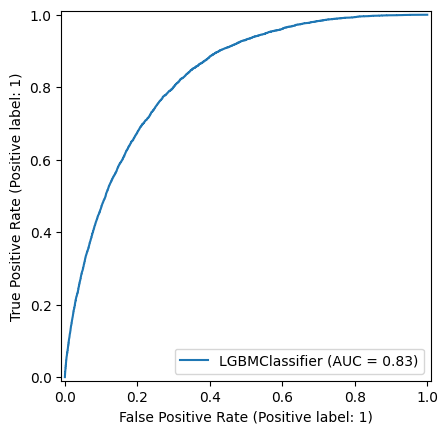

In [50]:
sklearn.metrics.RocCurveDisplay.from_estimator(clf_lgb, test_df_wo_target, test_target)

### RandomForest YDF

In [51]:
import tensorflow_decision_forests as tfdf
import ydf

In [52]:
model_ydf = ydf.RandomForestLearner(label="Diabetes_binary",
                                task=ydf.Task.CLASSIFICATION).train(Train_df)
# Note: ydf.Task.CLASSIFICATION is the default value of "task"

Train model on 202944 examples
Model trained in 0:03:55.973638


In [53]:
model_ydf.describe()

In [54]:
evaluation_ydf_train = model_ydf.evaluate(Train_df)
print(evaluation_ydf_train)

accuracy: 0.883387
confusion matrix:
    label (row) \ prediction (col)
    +--------+--------+--------+
    |        |      0 |      1 |
    +--------+--------+--------+
    |      0 | 173048 |   1619 |
    +--------+--------+--------+
    |      1 |  22047 |   6230 |
    +--------+--------+--------+
characteristics:
    name: '1' vs others
    ROC AUC: 0.882486
    PR AUC: 0.623563
    Num thresholds: 298
loss: 0.499727
num examples: 202944
num examples (weighted): 202944



In [55]:
evaluation_ydf = model_ydf.evaluate(Test_df)
print(evaluation_ydf)

accuracy: 0.865362
confusion matrix:
    label (row) \ prediction (col)
    +-------+-------+-------+
    |       |     0 |     1 |
    +-------+-------+-------+
    |     0 | 42915 |   752 |
    +-------+-------+-------+
    |     1 |  6079 |   990 |
    +-------+-------+-------+
characteristics:
    name: '1' vs others
    ROC AUC: 0.778773
    PR AUC: 0.391881
    Num thresholds: 291
loss: 0.833987
num examples: 50736
num examples (weighted): 50736



In [56]:
# import matplotlib.pyplot as plt
# import sklearn
# fig,ax = plt.subplots(figsize=(8,8))

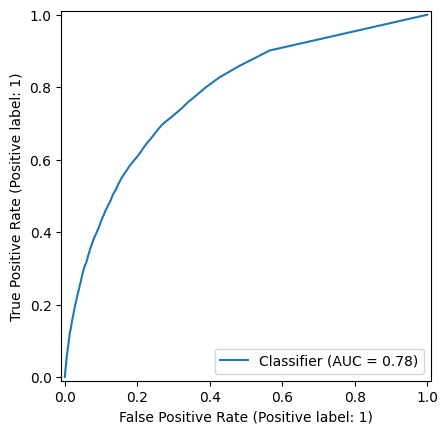

In [57]:
sklearn.metrics.RocCurveDisplay.from_predictions(test_target, model_ydf.predict(Test_df))


### RandomForest TF-DF

In [58]:
!pip install tensorflow_decision_forests
!pip install ydf -U

In [59]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(Train_df, label="Diabetes_binary")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(Test_df, label="Diabetes_binary")

In [60]:
t1 = train_ds.take(1)
for i in t1:
  print(i)

({'HighBP': <tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0

In [61]:
model_tfdf = tfdf.keras.RandomForestModel()
model_tfdf.fit(train_ds)

Use /tmp/tmp838doydz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:22.554359. Found 202944 examples.
Training model...
Model trained in 0:03:51.450477
Compiling model...
Model compiled.


In [62]:
model_tfdf.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (21):
	Age
	AnyHealthcare
	BMI
	CholCheck
	DiffWalk
	Education
	Fruits
	GenHlth
	HeartDiseaseorAttack
	HighBP
	HighChol
	HvyAlcoholConsump
	Income
	MentHlth
	NoDocbcCost
	PhysActivity
	PhysHlth
	Sex
	Smoker
	Stroke
	Veggies

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.              "GenHlth"  0.258433 ################
    2.               "HighBP"  0.254052 ###############
    3.                  "BMI"  0.219382 ############
    4.             "HighChol"  0.167264 ########
    5.                  "Age"  0.151577 ######
    6.             "DiffWalk"  0.118602 ####
    7. "HeartDis

In [63]:
model_tfdf.compile(metrics=["accuracy","AUC","Precision","Recall"])
## For other options, look at (https://www.tensorflow.org/api_docs/python/tf/keras/metrics)
model_tfdf.evaluate(test_ds, return_dict=True)

51/51 [==============================] - 7s 120ms/step - loss: 0.0000e+00 - accuracy: 0.8650 - auc: 0.7732 - precision: 0.5631 - recall: 0.1382


{'loss': 0.0,
 'accuracy': 0.8649873733520508,
 'auc': 0.7732384204864502,
 'precision': 0.5631123781204224,
 'recall': 0.13820907473564148}

51/51 [==============================] - 7s 128ms/step


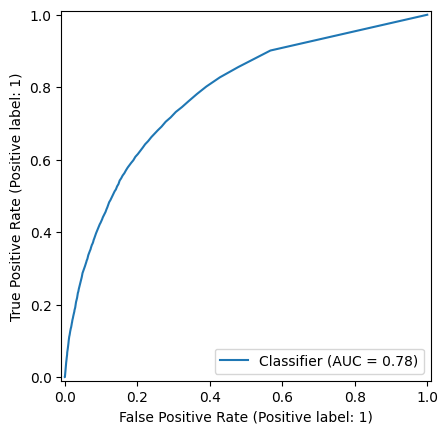

In [64]:
sklearn.metrics.RocCurveDisplay.from_predictions(test_target, model_tfdf.predict(test_ds))

51/51 [==============================] - 6s 113ms/step


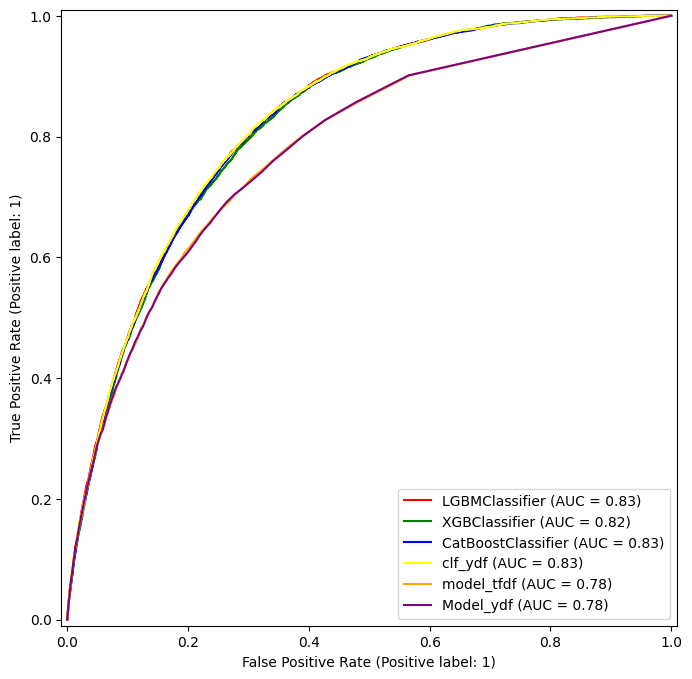

In [65]:
##
import matplotlib.pyplot as plt
import sklearn
fig,ax = plt.subplots(figsize=(8,8))

sklearn.metrics.RocCurveDisplay.from_estimator(clf_lgb, test_df_wo_target, test_target,ax=ax,color='red')
sklearn.metrics.RocCurveDisplay.from_estimator(clf_xgboost, test_df_wo_target, test_target,ax=ax,color='green')
sklearn.metrics.RocCurveDisplay.from_estimator(clf_catboost, test_df_wo_target, test_target,ax=ax,color='blue')
sklearn.metrics.RocCurveDisplay.from_predictions(test_target, clf_ydf.predict(Test_df),ax=ax,color='yellow', name= "clf_ydf")
sklearn.metrics.RocCurveDisplay.from_predictions(test_target, model_tfdf.predict(test_ds),ax=ax,color='orange', name = "model_tfdf")
sklearn.metrics.RocCurveDisplay.from_predictions(test_target, model_ydf.predict(Test_df),ax=ax,color='purple', name = "Model_ydf" )



Catboost, LightGBM, YDF-gradient boosted tree are the best performing for AUC from above ROC curve. AUC is a good balanced measure of sensitivity and specificity(1-FP), hence will use this to filter the other model and proceed with the three mentioned.

### Now looking at sensitivity, specificity and log loss to pick best model from Catboost, LightGBM, and YDF-gradient boosted trees

In [66]:
# ----Catboost Model----
print("CatBoost Model:")

# Testing data metrics
y_pred_catboost_test = clf_catboost.predict(test_df_wo_target)
cm_catboost_test = confusion_matrix(test_target, y_pred_catboost_test)
tn_catboost_test, fp_catboost_test, fn_catboost_test, tp_catboost_test = cm_catboost_test.ravel()
sensitivity_catboost_test = tp_catboost_test / (tp_catboost_test + fn_catboost_test)
specificity_catboost_test = tn_catboost_test / (tn_catboost_test + fp_catboost_test)

print(" Testing Metrics:")
print(f'  Accuracy: {clf_catboost.score(test_df_wo_target, test_target)}')
print(f'  ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_catboost.predict_proba(test_df_wo_target)[:,1])}')
print(f'  Sensitivity: {sensitivity_catboost_test}')
print(f'  Specificity: {specificity_catboost_test}')

# --- LightGBM Model ---
print("\n","LightGBM Model:")

# Testing data metrics
y_pred_lgb_test = clf_lgb.predict(test_df_wo_target)
cm_lgb_test = confusion_matrix(test_target, y_pred_lgb_test)
tn_lgb_test, fp_lgb_test, fn_lgb_test, tp_lgb_test = cm_lgb_test.ravel()
sensitivity_lgb_test = tp_lgb_test / (tp_lgb_test + fn_lgb_test)
specificity_lgb_test = tn_lgb_test / (tn_lgb_test + fp_lgb_test)

print("  Testing Metrics:")
print(f'  Accuracy: {clf_lgb.score(test_df_wo_target, test_target)}')
print(f'  ROC AUC: {sklearn.metrics.roc_auc_score(test_target, clf_lgb.predict_proba(test_df_wo_target)[:,1])}')
print(f'  Sensitivity: {sensitivity_lgb_test}')
print(f'  Specificity: {specificity_lgb_test}')

# --- YDF Model ---
print("\n", "YDF gradient boost Model:")

# Testing data metrics
y_pred_ydf_test_proba = clf_ydf.predict(Test_df) # Get probabilities for ROC AUC
y_pred_ydf_test = clf_ydf.predict_class(Test_df).astype(int) # Get predicted class for accuracy, sensitivity, specificity and convert to int
cm_ydf_test = confusion_matrix(test_target, y_pred_ydf_test)
tn_ydf_test, fp_ydf_test, fn_ydf_test, tp_ydf_test = cm_ydf_test.ravel()
sensitivity_ydf_test = tp_ydf_test / (tp_ydf_test + fn_ydf_test)
specificity_ydf_test = tn_ydf_test / (tn_ydf_test + fp_ydf_test)

print("  Testing Metrics:")
print(f'  Accuracy: {accuracy_score(test_target, y_pred_ydf_test)}')
print(f'  ROC AUC: {roc_auc_score(test_target, y_pred_ydf_test_proba)}')
print(f'  Sensitivity: {sensitivity_ydf_test}')
print(f'  Specificity: {specificity_ydf_test}')

CatBoost Model:
 Testing Metrics:
  Accuracy: 0.8647114474929044
  ROC AUC: 0.8254451636790006
  Sensitivity: 0.17230159852878765
  Specificity: 0.9768017038037877

 LightGBM Model:
  Testing Metrics:
  Accuracy: 0.8654998423210344
  ROC AUC: 0.8269113293973714
  Sensitivity: 0.16395529777903523
  Specificity: 0.9790688620697552

 YDF gradient boost Model:
  Testing Metrics:
  Accuracy: 0.8655786818038473
  ROC AUC: 0.8273007819441432
  Sensitivity: 0.16834064224076956
  Specificity: 0.9784505461790368


The three model above are very similar in performance but catboost has a minimal edge in sensitivity, so i willl go with catboost as the best model, but all model still perform very badly in sensitivity, worse than flipping a coin and relying on chance.

In [67]:
from sklearn.metrics import log_loss

# --- CatBoost Model ---
y_pred_catboost_proba = clf_catboost.predict_proba(test_df_wo_target)
logloss_catboost = log_loss(test_target, y_pred_catboost_proba)
print(f"CatBoost Model Log Loss: {logloss_catboost}")

# --- LightGBM Model ---
y_pred_lgb_proba = clf_lgb.predict_proba(test_df_wo_target)
logloss_lgb = log_loss(test_target, y_pred_lgb_proba)
print(f"LightGBM Model Log Loss: {logloss_lgb}")

# --- YDF Gradient Boost Model ---
y_pred_ydf_test_proba = clf_ydf.predict(Test_df)
logloss_ydf = log_loss(test_target, y_pred_ydf_test_proba)
print(f"YDF Gradient Boost Model Log Loss: {logloss_ydf}")

CatBoost Model Log Loss: 0.3163151786192577
LightGBM Model Log Loss: 0.31434652438676736
YDF Gradient Boost Model Log Loss: 0.31442353343967117


Even though catboost has higher log_loss amongst the three they are baerly different hence,i would still go with catbooost as best model due to higher sensitivity.

### Modeling with sklearn and tensorflow Multi-layer Perceptron


In [75]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [76]:
train_df_wo_target.head(2)

HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
153147       0         0          1   28       1       0   
176137       1         0          1   23       1       0   

        HeartDiseaseorAttack  PhysActivity  Fruits  Veggies  ...  \
153147                     0             1       1        1  ...   
176137                     0             1       1        1  ...   

        AnyHealthcare  NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  \
153147              1            0        2         0         0         0   
176137              1            0        2         0         0         0   

        Sex  Age  Education  Income  
153147    1    2          4       5  
176137    1   13          4       7  

[2 rows x 21 columns]

In [82]:
#Define SKlearn MLP model
SK_MLP_model = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(50,),
                          activation='relu',
                          solver='adam',
                          early_stopping=True,
                          max_iter=200))
])

In [84]:
# Train
SK_MLP_model.fit(train_df_wo_target, train_target)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(50,)))])

In [86]:
# Test
test_accuracy = SK_MLP_model.score(test_df_wo_target, test_target)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.8652830337432986


SK_MLP_model Training Metrics:
  Accuracy: 0.8683
  ROC AUC: 0.8341
  Sensitivity: 0.1490
  Specificity: 0.9847

SK_MLP_model Testing Metrics:
  Accuracy: 0.8653
  ROC AUC: 0.8260
  Sensitivity: 0.1392
  Specificity: 0.9828
  Log Loss: 0.3155


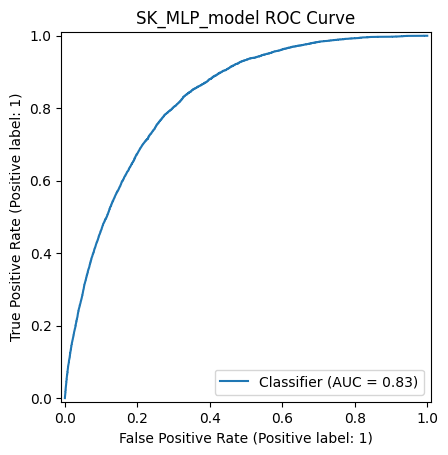

In [87]:
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss, RocCurveDisplay
import matplotlib.pyplot as plt

# Get predictions for training data
y_pred_mlp_train = SK_MLP_model.predict(train_df_wo_target)
y_pred_mlp_train_proba = SK_MLP_model.predict_proba(train_df_wo_target)

# Calculate training metrics
cm_mlp_train = confusion_matrix(train_target, y_pred_mlp_train)
tn_mlp_train, fp_mlp_train, fn_mlp_train, tp_mlp_train = cm_mlp_train.ravel()
sensitivity_mlp_train = tp_mlp_train / (tp_mlp_train + fn_mlp_train)
specificity_mlp_train = tn_mlp_train / (tn_mlp_train + fp_mlp_train)

print("SK_MLP_model Training Metrics:")
print(f"  Accuracy: {SK_MLP_model.score(train_df_wo_target, train_target):.4f}")
print(f"  ROC AUC: {roc_auc_score(train_target, y_pred_mlp_train_proba[:,1]):.4f}")
print(f"  Sensitivity: {sensitivity_mlp_train:.4f}")
print(f"  Specificity: {specificity_mlp_train:.4f}")

# Get predictions for test data
y_pred_mlp_test = SK_MLP_model.predict(test_df_wo_target)
y_pred_mlp_test_proba = SK_MLP_model.predict_proba(test_df_wo_target)

# Calculate testing metrics
accuracy_mlp_test = SK_MLP_model.score(test_df_wo_target, test_target)
roc_auc_mlp_test = roc_auc_score(test_target, y_pred_mlp_test_proba[:,1])
logloss_mlp_test = log_loss(test_target, y_pred_mlp_test_proba)

cm_mlp_test = confusion_matrix(test_target, y_pred_mlp_test)
tn_mlp_test, fp_mlp_test, fn_mlp_test, tp_mlp_test = cm_mlp_test.ravel()
sensitivity_mlp_test = tp_mlp_test / (tp_mlp_test + fn_mlp_test)
specificity_mlp_test = tn_mlp_test / (tn_mlp_test + fp_mlp_test)

print("\nSK_MLP_model Testing Metrics:")
print(f"  Accuracy: {accuracy_mlp_test:.4f}")
print(f"  ROC AUC: {roc_auc_mlp_test:.4f}")
print(f"  Sensitivity: {sensitivity_mlp_test:.4f}")
print(f"  Specificity: {specificity_mlp_test:.4f}")
print(f"  Log Loss: {logloss_mlp_test:.4f}")

# Plot ROC curve
RocCurveDisplay.from_predictions(test_target, y_pred_mlp_test_proba[:,1])
plt.title('SK_MLP_model ROC Curve')
plt.show()

#### Now generating a tensor flow MLP model


In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam




In [92]:
# model with explicit Input layer
TF_MLP_model = Sequential([
    Input(shape=(21,)),            # Explicit input layer for 21 features
    Dense(64, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid') # Output layer (binary)
])

# Compiling the model
TF_MLP_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
TF_MLP_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

TF_MLP_model trained successfully!

TF_MLP_model Test Accuracy: 0.8644
TF_MLP_model Testing Metrics:
  Accuracy: 0.8644
  ROC AUC: 0.8246
  Sensitivity: 0.1607
  Specificity: 0.9783
  Log Loss: 0.3166


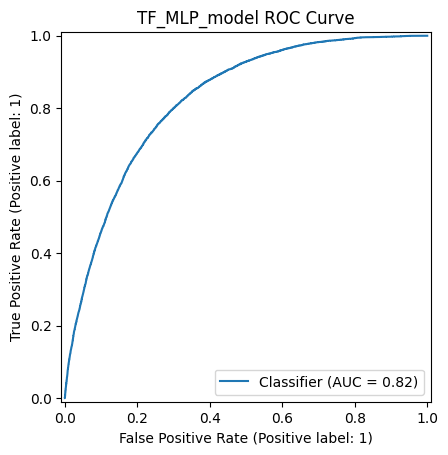

In [93]:
# Convert pandas DataFrames to NumPy arrays for TensorFlow
X_train_tf = train_df_wo_target.values
y_train_tf = train_target.values
X_test_tf = test_df_wo_target.values
y_test_tf = test_target.values

# Train the TF_MLP_model
history = TF_MLP_model.fit(
    X_train_tf,
    y_train_tf,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

print("TF_MLP_model trained successfully!")

# Evaluate the model on the test set
loss, accuracy = TF_MLP_model.evaluate(X_test_tf, y_test_tf, verbose=0)
print(f"\nTF_MLP_model Test Accuracy: {accuracy:.4f}")

# Get predictions for ROC AUC, Sensitivity, Specificity, and Log Loss
y_pred_tf_mlp_test_proba = TF_MLP_model.predict(X_test_tf, verbose=0)
y_pred_tf_mlp_test = (y_pred_tf_mlp_test_proba > 0.5).astype(int)

# Calculate ROC AUC
roc_auc_tf_mlp_test = sklearn.metrics.roc_auc_score(y_test_tf, y_pred_tf_mlp_test_proba)

# Calculate Log Loss
logloss_tf_mlp_test = sklearn.metrics.log_loss(y_test_tf, y_pred_tf_mlp_test_proba)

# Calculate Confusion Matrix for Sensitivity and Specificity
cm_tf_mlp_test = confusion_matrix(y_test_tf, y_pred_tf_mlp_test)
tn_tf_mlp_test, fp_tf_mlp_test, fn_tf_mlp_test, tp_tf_mlp_test = cm_tf_mlp_test.ravel()
sensitivity_tf_mlp_test = tp_tf_mlp_test / (tp_tf_mlp_test + fn_tf_mlp_test)
specificity_tf_mlp_test = tn_tf_mlp_test / (tn_tf_mlp_test + fp_tf_mlp_test)

print("TF_MLP_model Testing Metrics:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  ROC AUC: {roc_auc_tf_mlp_test:.4f}")
print(f"  Sensitivity: {sensitivity_tf_mlp_test:.4f}")
print(f"  Specificity: {specificity_tf_mlp_test:.4f}")
print(f"  Log Loss: {logloss_tf_mlp_test:.4f}")

# Plot ROC curve
sklearn.metrics.RocCurveDisplay.from_predictions(y_test_tf, y_pred_tf_mlp_test_proba)
plt.title('TF_MLP_model ROC Curve')
plt.show()

In [95]:
from sklearn.metrics import log_loss

# Gathering Metrics for all models

# XGBoost
y_pred_xgboost_proba = clf_xgboost.predict_proba(test_df_wo_target)
logloss_xgboost = log_loss(test_target, y_pred_xgboost_proba)
sensitivity_xgboost = tp_xgboost / (tp_xgboost + fn_xgboost)



# YDF Random Forest (model_ydf)
y_pred_model_ydf_proba = model_ydf.predict(Test_df)
logloss_model_ydf = log_loss(test_target, y_pred_model_ydf_proba)
cm_model_ydf_test = confusion_matrix(test_target, model_ydf.predict_class(Test_df).astype(int))
tn_model_ydf, fp_model_ydf, fn_model_ydf, tp_model_ydf = cm_model_ydf_test.ravel()
sensitivity_model_ydf = tp_model_ydf / (tp_model_ydf + fn_model_ydf)

# TF-DF Random Forest (model_tfdf)

metrics_tfdf = model_tfdf.evaluate(test_ds, return_dict=True, verbose=0)
sensitivity_model_tfdf = metrics_tfdf['recall']
logloss_model_tfdf = metrics_tfdf['loss']

# rest were all prevoiusly calculated

# Creating a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': [
        'XGBoost',
        'LightGBM',
        'CatBoost',
        'YDF Gradient Boosted Trees',
        'YDF Random Forest',
        'TF-DF Random Forest',
        'Scikit-learn MLP',
        'TensorFlow Keras MLP'
    ],
    'Sensitivity': [
        sensitivity_xgboost,
        sensitivity_lgb_test,
        sensitivity_catboost_test,
        sensitivity_ydf_test,
        sensitivity_model_ydf,
        sensitivity_model_tfdf,
        sensitivity_mlp_test,
        sensitivity_tf_mlp_test
    ],
    'Log Loss': [
        logloss_xgboost,
        logloss_lgb,
        logloss_catboost,
        logloss_ydf,
        logloss_model_ydf,
        logloss_model_tfdf,
        logloss_mlp_test,
        logloss_tf_mlp_test
    ]
})

print("\n--- Model Comparison (Sensitivity vs. Log Loss) in descending order of importance ---")
print(comparison_df.sort_values(by='Sensitivity', ascending=False).to_markdown(index=False))



--- Model Comparison (Sensitivity vs. Log Loss) in descending order of importance ---
| Model                      |   Sensitivity |   Log Loss |
|:---------------------------|--------------:|-----------:|
| CatBoost                   |      0.172302 |   0.316315 |
| YDF Gradient Boosted Trees |      0.168341 |   0.314424 |
| XGBoost                    |      0.166502 |   0.317443 |
| LightGBM                   |      0.163955 |   0.314347 |
| TensorFlow Keras MLP       |      0.160702 |   0.316586 |
| YDF Random Forest          |      0.140048 |   0.557444 |
| Scikit-learn MLP           |      0.139199 |   0.315508 |
| TF-DF Random Forest        |      0.138209 |   0        |


### It makes sense for the sensitivity to be low and log loss high since no feature had a correlation value of 3 or above with outcome variable. The data set has poor features and better feature sets are needed if we want better results in capturing diabetic and pre-diabetic patients
